In [1]:
import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import  Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
#import cv2
from tensorflow.keras.preprocessing import image

2022-04-25 23:24:51.761939: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-25 23:24:51.761963: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
IMAGE_W = 224
IMAGE_H = 224

In [3]:
def get_model():
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
    for layer in model_vgg16_conv.layers:
        layer.trainable = False
    input = Input(shape=(IMAGE_W, IMAGE_H, 3), name='image_input')
    output_vgg16_conv = model_vgg16_conv(input)

    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    x = Dense(5, activation='sigmoid', name='predictions')(x)

    my_model = Model(inputs=input, outputs=x)
    my_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['BinaryAccuracy'])

    return my_model

model = get_model()

2022-04-25 23:25:55.449507: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-25 23:25:55.449619: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-25 23:25:55.449678: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cessna): /proc/driver/nvidia/version does not exist
2022-04-25 23:25:55.518379: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-25 23:25:57.811340: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10

In [4]:
csv_file = "dataset/miml_labels_1.csv"
image_path ="dataset/images"
train = pd.read_csv(csv_file)
train.head

<bound method NDFrame.head of      Filenames  desert  mountains  sea  sunset  trees
0        1.jpg       1          0    0       0      0
1        2.jpg       1          0    0       0      0
2        3.jpg       1          0    0       0      0
3        4.jpg       1          1    0       0      0
4        5.jpg       1          0    0       0      0
...        ...     ...        ...  ...     ...    ...
1995  1996.jpg       0          0    0       0      1
1996  1997.jpg       0          0    0       0      1
1997  1998.jpg       0          0    0       0      1
1998  1999.jpg       0          0    0       0      1
1999  2000.jpg       0          0    0       0      1

[2000 rows x 6 columns]>

In [5]:
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size, size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.size = size

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)

    def __len__(self):
        return self.size // self.batch_size

class Dataset:
    def __init__(self, data, label, w, h):
        # the paths of images
        self.data = data
        # the paths of segmentation images
        self.label = label
        self.w = w
        self.h = h

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        # read data
        img = image.load_img(image_path + '/' + str(self.data[i][0]),target_size=(IMAGE_W,IMAGE_H,3))
        img = image.img_to_array(img)
        img = img/255
        label = self.label[i]
        return img, label

In [6]:
y = np.array(train.drop(columns=["Filenames"]))
X = np.array(train)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [7]:
train_dataset = Dataset(X_train, y_train, IMAGE_W, IMAGE_H)
test_dataset = Dataset(X_test, y_test, IMAGE_W, IMAGE_H)

train_loader = Dataloader(train_dataset, 64, len(train_dataset))
test_loader = Dataloader(test_dataset, 64, len(test_dataset))

In [8]:
from PIL import Image

In [9]:
model.fit_generator(train_loader, epochs=10, validation_data=test_loader)
model.save("model.h5")

/tmp/ipykernel_4243/412069453.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_loader, epochs=10, validation_data=test_loader)


Epoch 1/10
28/28 [==============================] - 530s 19s/step - loss: 1.1716 - binary_accuracy: 0.7627 - val_loss: 0.3153 - val_binary_accuracy: 0.8594
Epoch 2/10
28/28 [==============================] - 495s 18s/step - loss: 0.3152 - binary_accuracy: 0.8625 - val_loss: 0.2670 - val_binary_accuracy: 0.8875
Epoch 3/10
28/28 [==============================] - 495s 18s/step - loss: 0.2475 - binary_accuracy: 0.8943 - val_loss: 0.2542 - val_binary_accuracy: 0.8958
Epoch 4/10
28/28 [==============================] - 495s 18s/step - loss: 0.2122 - binary_accuracy: 0.9100 - val_loss: 0.2393 - val_binary_accuracy: 0.9010
Epoch 5/10
28/28 [==============================] - 494s 18s/step - loss: 0.1886 - binary_accuracy: 0.9244 - val_loss: 0.2354 - val_binary_accuracy: 0.9073
Epoch 6/10
28/28 [==============================] - 499s 18s/step - loss: 0.1728 - binary_accuracy: 0.9296 - val_loss: 0.2505 - val_binary_accuracy: 0.8958
Epoch 7/10
28/28 [==============================] - 493s 18s/ste

In [22]:
img = image.load_img("dataset/images/152.jpg", target_size=(IMAGE_W,IMAGE_H,3))
img = image.img_to_array(img)
img = img/255
tensor = np.expand_dims(img, axis=0)

In [23]:
y_pred = model.predict(tensor)
y_pred

array([[0.99449176, 0.01507345, 0.00388798, 0.03072679, 0.00864956]],
      dtype=float32)

In [24]:
classes = np.array(train.columns[1:])
top_3 = np.argsort(y_pred[0])[:-4:-1]
top_3

array([0, 3, 1])

desert (0.994)
sunset (0.0307)
mountains (0.0151)


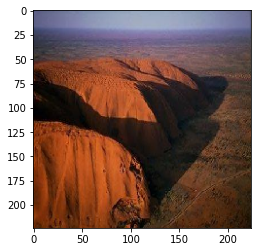

In [25]:
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(y_pred[0][top_3[i]]))
plt.imshow(img)